# Exploring and Benchmarking XGBoost Against Other Machine Learning Models

---

## Part I: Understanding XGBoost

### Introduction
- Briefly introduce machine learning and the role of ensemble learning

### Background on Boosting
- Explain the concept of boosting in machine learning. Refresh the concept of boosing with an image depiction?
    - Boosting is an ensemble method that trains sequential models on the errors, or residuals, of previous models, thus creating a strong learner via iteration on many weak learners. **ISL**  **& BOOK 92**

- Historical evolution leading to gradient boosting.
    - Boositng and other ensemble methods were popularized due standard decision trees overfitting data. Boosting allowed for a more generalizable model with "consistency and power". **BOOK 110**

### XGBoost Overview
- Detailed explanation of XGBoost and its core algorithm.
    - XGBoost, which stands for "Extreme Gradient Boosting", is an open source software who's algorithm uses gradient boosting to . Averages or the majority class are considered when outputing a result. **Read the docs: tutorials**

- Advantages of XGBoost over other boosting methods.
    - XGBoost is extremely fast, memory efficient, and can perform advance model operations **Read the docs: faq** **& Book 57**
    - Not only is XGBoost fast, but it can provide better accuracy than other gradient boosting models. Speed can be attributed to it's ability to handle missing values, it storing sparce matrices of data, computing in parallel with blocks, being cache-aware. **Book 129**  
        - missing values?????
        -  from original XGBoost papaer: A Scalable Tree Boosting System, the sparsity-aware split-finding algorithm performed 50 times faster than the standard approach on the All-State-10K dataset.**Book 112**
        - Parallel computing occurs when multiple computational units are working together on the same problem at the same time. XGBoost sorts and compresses the data into blocks. These blocks may be distributed to multiple machines, or to external memory (out of core). Sorting the data is faster with blocks. The split-finding algorithm takes advantage of blocks and the search for quantiles is faster due to blocks. In each of these cases, XGBoost provides parallel computing to expedite the model-building process. **Book 112**
        - According to XGBoost: A Scalable Tree Boosting System, prefetching lengthens read/write dependency and reduces runtimes by approximately 50% for datasets with a large number of rows. **BOOK 112**
    - And accuracy can be attributed to XGBoost's built-in regularization. 
        - Regularization is the process of adding information to reduce variance and prevent overfitting. **BOOK 112**


### Key Concepts and Features of XGBoost
- Discuss tree boosting, regularized learning, and model complexity.
- Overview of handling missing data, parallel processing, and scalability.

### XGBoost Parameters
- List and explain crucial XGBoost hyperparameters.
    -  XGBoost is easy to use with scikit-learn since "all standard methods are available" and scikit-learn's functions like train_test_split, and GridSearchCV can be combined with XGBoost models. **BOOK 117**
    - Some hyperparameters are required to build a specific model. 
        - General parameters determine what booster we will be using. **Read the docs: parameter**
        - Booster parameters will depend on the general parameter chosen. **Read the docs: parameter**
        - Learning task parameters determine the "objective", or scoring metric, and the evaluation metric. **Read the docs: parameter**
    - These hyperparameters "are designed to improve upon accuracy and speed. **Book 130**

    - Hyperparameters of specific models are similar to scikit-learn's hyperparameters:

<img src="../images/XGBoost_hyperparameters.png" alt="Some of XGBoost's core hyperparameters" style="width: 500px;"/>


- Show how these parameters can affect model performance. **Code for this?**



In [ ]:
# TODO

### Installation and Setup
- ~~Guide on setting up XGBoost in a development environment.~~ May take up too much time. Perhaps link the documentation page on how to install and discuss to install via pip or conda?

### Data Preparation
- Discuss the preprocessing required for optimal XGBoost performance.

### Model Training with XGBoost
- Step-by-step process of training an XGBoost model.
- Techniques for evaluating model performance. 

- **Do this in the code block above where we're demo-ing parameters and hyperparameters**
    - page 119 for step by step

### Interpretation of Results
- How to interpret model outputs, importance scores, and diagnostics.

---

## Part II: Performance Comparison of XGBoost

### <u>Benchmarking Goals</u>
- Define the objectives of the performance comparison.

The objectives of the performance comparison are to:
- Compare the performance of XGBoost against other machine learning models.
- Determine the optimal hyperparameters for each model.
- Identify the best model for the given dataset (may or may not be XGBoost).

### <u>Selection of Competing Models</u>

For <u>classification</u>, we're using six machine learning models for comparison. Here is a brief description of each:

1. **MLP (Multi-Layer Perceptron)**: A type of neural network with multiple hidden layers, effective for complex classification tasks.

2. **GradientBoosting**: A simpler gradient boosting classifier with fewer hyperparameters, ideal as a starting point.

3. **k-NN (k-Nearest Neighbors)**: Simple for low-dimensional data but computationally heavy for large datasets.

4. **Random Forest**: A popular method using multiple decision trees, effective for both classification and regression.

5. **SVM (Support Vector Machine)**: Effective in high-dimensional spaces but can be slower than gradient boosting methods.

6. **XGBoost (Extreme Gradient Boosting)**: Highly efficient and versatile, suitable for various supervised learning tasks.

For <u>regression</u>, we're using the same methods as above, but replacing k-NN with **Linear Regression** - a simple yet effective model for regression tasks.


### <u>Dataset Description</u>
- Introduce the dataset(s) used for the comparison.
- Include feature descriptions and any preprocessing steps.

#### Dataset 1: [The Titanic Dataset](https://www.kaggle.com/c/titanic/data) (famous for classification problems):
| Attribute  | Description                                       | Key                                        |
|-----------|-------------------------------------------------|--------------------------------------------|
| PassengerId | Unique ID for each passenger                   |                                            |
| Name      | Passenger name                                   |                                            |
| pclass    | Ticket class                                     | 1 = 1st, 2 = 2nd, 3 = 3rd                  |
| sex       | Sex                                              |                                            |
| Age       | Age in years                                     |                                            |
| sibsp     | # of siblings / spouses aboard the Titanic       |                                            |
| parch     | # of parents / children aboard the Titanic       |                                            |
| ticket    | Ticket number                                    |                                            |
| fare      | Passenger fare                                   |                                            |
| cabin     | Cabin number                                     |                                            |
| embarked  | Port of Embarkation                              | C = Cherbourg, Q = Queenstown, S = Southampton |
| survived  | Survived or not                                         | 0 = No, 1 = Yes                            |


#### Dataset 2: [The Boston Housing Dataset](https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data) (famous for regression problems):
| Attribute | Description                                           | Unit        |
|-----------|-------------------------------------------------------|-------------|
| CRIM      | Per capita crime rate by town                         | -           |
| ZN        | Proportion of residential land zoned for large lots   | -           |
| INDUS     | Proportion of non-retail business acres per town      | -           |
| CHAS      | Charles River dummy variable                          | 1 or 0      |
| NOX       | Nitric oxides concentration                           | parts/10M   |
| RM        | Average number of rooms per dwelling                  | -           |
| AGE       | Proportion of owner-occupied units built pre-1940     | -           |
| DIS       | Weighted distances to five Boston employment centres | -           |
| RAD       | Index of accessibility to radial highways             | -           |
| TAX       | Full-value property-tax rate                          | $/10k       |
| PTRATIO   | Pupil-teacher ratio by town                           | -           |
| B         | Equation result of black population proportion        | -           |
| LSTAT     | Percentage of lower status population                 | %           |
| MEDV      | Median value of owner-occupied homes                  | k$          |


### <u>Performance Metrics</u>
- Define the metrics for evaluating model performance (e.g., accuracy, F1 score, ROC-AUC).

For our classification models, we use six metrics to evaluate performance:

1. **Accuracy**: Ratio of correct predictions. Useful overall but can mislead in imbalanced datasets.

2. **Precision**: Ratio of correct positive predictions. Vital when false positives are costly.

3. **Recall**: Ratio of correct positives out of all actual positives. Key when false negatives are costly.

4. **F1-Score**: Balances Precision and Recall. Used when both metrics are important.

5. **AUC-ROC**: Indicates the model's ability to differentiate classes. Higher values are better.

6. **Training Time**: Measures computational efficiency, important in scenarios with computational constraints.

For our regression models, we use three metrics to evaluate performance:

1. **Mean Absolute Error (MAE)**: Average of absolute errors. Useful for datasets with outliers.

2. **Mean Squared Error (MSE)**: Average of squared errors. Useful for datasets without outliers.

3. **Training Time**: Measures computational efficiency, important in scenarios with computational constraints.

### <u>Cross-Validation Strategy</u>
- Explain the cross-validation process to ensure fairness in comparison.

### <u>Hyperparameter Tuning</u>
- How each model's hyperparameters are tuned for optimal performance.

### <u>Model Training and Evaluation</u>
- Train the selected models on the dataset.
- Evaluate and compare their performance using the defined metrics.

Using default params for all models, then using tuned versions of each model.  Each with reduced simple dataset and transformed dataset.

In [7]:
# Standard libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# Sklearn modules
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, average_precision_score, classification_report, confusion_matrix, 
                             f1_score, precision_recall_curve, precision_score, recall_score, roc_auc_score, 
                             roc_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, mean_absolute_error, mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, MinMaxScaler, OneHotEncoder, OrdinalEncoder, 
                                   PolynomialFeatures, StandardScaler)
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, LogisticRegression

# Third-party libraries
from xgboost import XGBClassifier, XGBRegressor

# pd max cols
pd.set_option('display.max_columns', 500)

In [2]:
def titanic_data_transformed(t_data):

    # Group ticket feature extraction
    group_tickets = t_data['Ticket'].value_counts() > 1
    t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if group_tickets[x] else 0)
    t_data['Group_Size'] = t_data['Ticket'].map(t_data['Ticket'].value_counts())

    # Functions for title and family size extraction
    def get_title(data):
        titles = data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
        common_titles = titles.value_counts().nlargest(6).index
        return titles.where(titles.isin(common_titles), 'Other')

    def get_family_size(data):
        return data['SibSp'] + data['Parch'] + 1

    # Transformation pipelines
    numerical_features = ['Age', 'Fare', 'FamilySize', 'Group_Size']
    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Apply the custom transformations
    t_data['Title'] = get_title(t_data)
    t_data['FamilySize'] = get_family_size(t_data)

    # Column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Fit the transformer and transform the data
    transformed_data = preprocessor.fit_transform(t_data)

    # Getting the column names for numerical features
    numerical_cols = numerical_features

    # Getting the column names for categorical features
    categorical_cols = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

    # Combine all column names
    all_cols = list(numerical_cols) + list(categorical_cols)

    # Add any remaining columns that were 'passed through'
    pass_through_cols = [col for col in t_data.columns if col not in numerical_features + categorical_features]
    all_cols.extend(pass_through_cols)

    # Create the DataFrame
    transformed_df = pd.DataFrame(transformed_data, columns=all_cols)

    transformed_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

    # Set all dtypes to float
    transformed_df = transformed_df.astype(float)

    return transformed_df

In [3]:
# # Load Titanic data
t_data = pd.read_csv('../../data_science_analytics_class/Data/titanic.csv')

t_data_reduced = t_data.drop(columns=['Name', 'Ticket', 'Cabin'])
titanic_data = t_data_reduced

# map Embarked to numeric values and sex to numeric values
titanic_data['Embarked'] = titanic_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 1, 'female': 0})

# fill missing age with mean based on Pclass
titanic_data['Age'] = titanic_data['Age'].fillna(titanic_data.groupby('Pclass')['Age'].transform('mean'))

# drop missing embarked rows
titanic_data.dropna(subset=['Embarked'], inplace=True)

# Load transformed titanic data
# titanic_data = titanic_data_transformed(t_data)

In [8]:
# Load Boston housing data
b_data = pd.read_csv('../../data_science_analytics_class/Data/boston_housing.csv')

In [ ]:
# transformed_titanic_data = titanic_transformed(t_data)
# # plot correlation matrix for transformed data with blue color map
# plt.figure(figsize=(16, 6))
# plt.title('Correlation Matrix')
# plt.imshow(transformed_titanic_data.corr(), cmap='Blues', interpolation='nearest')
# plt.xticks(np.arange(len(transformed_titanic_data.columns)), transformed_titanic_data.columns, rotation=90)
# plt.yticks(np.arange(len(transformed_titanic_data.columns)), transformed_titanic_data.columns)
# plt.colorbar()
# plt.show()

##### Classification 
---

In [ ]:
from sklearn.model_selection import GridSearchCV

# Feature matrix X, target vector y
X = titanic_data.drop(['Survived'], axis=1)
y = titanic_data['Survived']

# Define the models and their corresponding parameter grids
model_params = {
    "MLP": {
        "model": MLPClassifier(max_iter=10000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam", "sgd"]
        }
    },
    # "GradientBoosting": {
    #     "model": GradientBoostingClassifier(),
    #     "params": {
    #         "n_estimators": [100, 200],
    #         "learning_rate": [0.01, 0.1]
    #     }
    # },
    "k-NN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1]
        }
    }
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function to perform grid search and evaluate each model
def grid_search_model(model_info, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    scores = {
        "Best Parameters": grid_search.best_params_,
        "Best Score": grid_search.best_score_,
        "Test Accuracy": accuracy_score(y_test, y_pred)
        # Add other metrics as needed
    }
    return scores

# Evaluate each model
grid_results = {}
for name, model_info in model_params.items():
    grid_results[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)

# Convert results to DataFrame for display
grid_results_df = pd.DataFrame(grid_results).T
styled_grid_results = grid_results_df.style.set_precision(3)
styled_grid_results

In [11]:
# Feature matrix X, target vector y
X = titanic_data.drop(['Survived'], axis=1)
y = titanic_data['Survived']


models = {
    "MLP": MLPClassifier(max_iter=1000),
    # "GradientBoosting": GradientBoostingClassifier(),
    "k-NN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    end = time.time()
    training_time = end - start
    scores = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted'),
        # "AUC-ROC": roc_auc_score(y_test, y_score, average='weighted'),
        # "AUC-PR": average_precision_score(y_test, y_score, average='weighted'), # Not directly supported for multiclass
        "Training Time": training_time
    }
    # Create plots to add to dictionary
    cm = confusion_matrix(y_test, y_pred)
    cm_display_data = (cm, model.classes_)
    
    # Store the model and test set for ROC curve plotting
    roc_data = (model, X_test, y_test)

    plots = {
        "Confusion_Matrix": cm_display_data,
        "ROC_Curve": roc_data
    }
    return scores, plots

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

results = {}
plots = {}
for name, model in models.items():
    results[name], plots[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

results_df = pd.DataFrame(results)
def highlight_max(s):
    '''
    Highlight the maximum value in a Series with a green background.
    '''
    is_max = s == s.max()
    return ['background-color: green' if cell else '' for cell in is_max]
# Transpose the DataFrame for better readability
results_df_transposed = results_df.T
# Apply the highlighting style
styled_results = results_df_transposed.style.apply(highlight_max).set_precision(3)
styled_results

/tmp/ipykernel_41079/1320729449.py:61: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_results = results_df_transposed.style.apply(highlight_max).set_precision(3)


,Accuracy,Precision,Recall,F1-Score,Training Time
MLP,0.731,0.732,0.731,0.732,0.620
k-NN,0.610,0.590,0.610,0.595,0.051
Random Forest,0.798,0.797,0.798,0.797,0.428
SVM,0.655,0.679,0.655,0.558,0.236
XGBoost,0.803,0.800,0.803,0.800,0.111


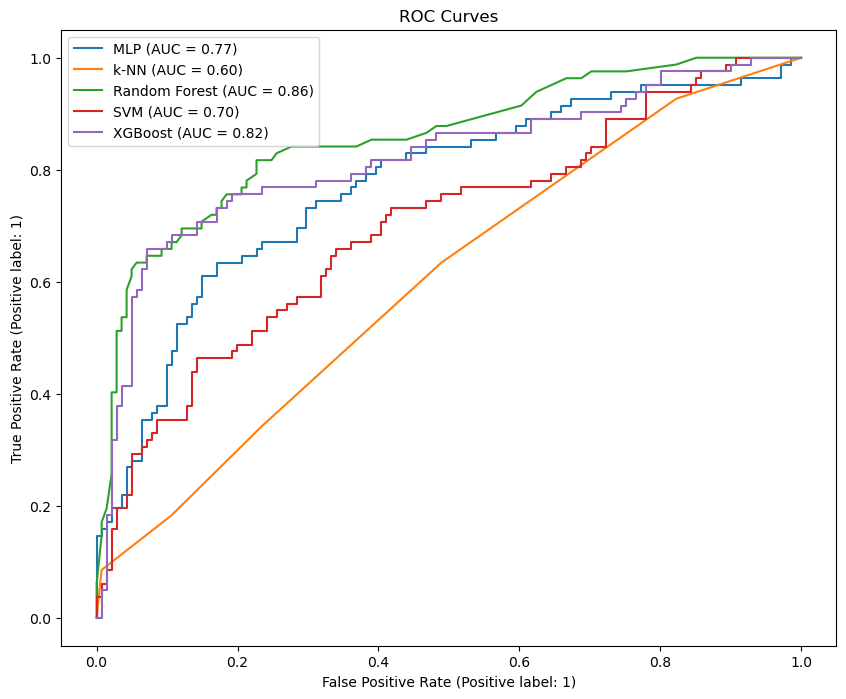

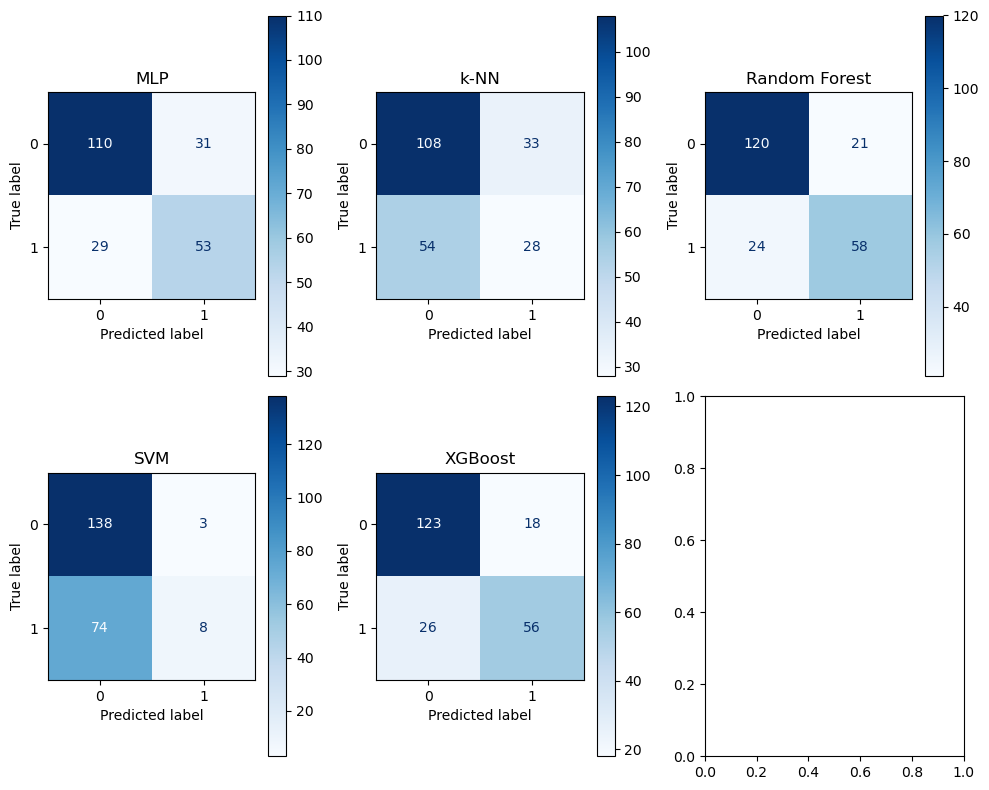

In [12]:

# Plot ROC curves in a separate figure
fig_roc, ax_roc = plt.subplots(figsize=(10, 8))
for model_name in models.keys():
    model, X_test, y_test = plots[model_name]["ROC_Curve"]
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax_roc, name=model_name)
ax_roc.set_title('ROC Curves')
ax_roc.legend()
plt.show()

# Plot confusion matrices in another separate figure
fig_cm, axes_cm = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))  # Adjust nrows and ncols based on the number of models
axes_cm = axes_cm.flatten()  # Flatten the array for easy iteration
for i, model_name in enumerate(models.keys()):
    cm, classes = plots[model_name]["Confusion_Matrix"]
    # Plot the confusion matrix, with blue color
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(ax=axes_cm[i], cmap='Blues')
    # ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes).plot(ax=axes_cm[i])
    axes_cm[i].set_title(f"{model_name}")
fig_cm.tight_layout()
# plt.show()

##### Regression
---

In [25]:
# Feature matrix X, target vector y
X = b_data.drop(['MEDV'], axis=1)
y = b_data['MEDV']


models = {
    "MLP": MLPRegressor(max_iter=1000),
    # "GradientBoosting": GradientBoostingRegressor(),
    "LinearRegression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor()
}

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    end = time.time()
    training_time = end - start
    scores = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R^2": r2_score(y_test, y_pred),
        "Training Time": training_time
    }
    return scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test)

results_df = pd.DataFrame(results)
def highlight_min(s):
    '''
    Highlight the minimum value in a Series with a green background.
    '''
    is_min = s == s.min()
    return ['background-color: green' if cell else '' for cell in is_min]
# Transpose the DataFrame for better readability
results_df_transposed = results_df.T
# Apply the highlighting style
styled_results = results_df_transposed.style.apply(highlight_min).set_precision(3)
styled_results

/tmp/ipykernel_26811/3172889498.py:45: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_results = results_df_transposed.style.apply(highlight_min).set_precision(3)


,MAE,MSE,R^2,Training Time
MLP,3.195,19.241,0.725,0.954
GradientBoosting,2.036,8.980,0.872,0.168
LinearRegression,3.061,22.099,0.684,0.003
Random Forest,2.109,10.088,0.856,0.363
SVR,4.462,49.284,0.296,0.012
XGBoost,2.140,10.061,0.856,0.075


In [27]:
# Feature matrix X, target vector y
X = b_data.drop(['MEDV'], axis=1)
y = b_data['MEDV']

# Define the models and their corresponding parameter grids
model_params = {
    "MLP": {
        "model": MLPRegressor(max_iter=10000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ["relu", "tanh"],
            "solver": ["adam", "sgd"]
        }
    },
    # "GradientBoosting": {
    #     "model": GradientBoostingRegressor(),
    #     "params": {
    #         "n_estimators": [100, 200],
    #         "learning_rate": [0.01, 0.1]
    #     }
    # },
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "fit_intercept": [True, False],
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20]
        }
    },
    "SVM": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1]
        }
    }
}

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function to perform grid search and evaluate each model
def grid_search_model(model_info, X_train, X_test, y_train, y_test):
    grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    scores = {
        "Best Parameters": grid_search.best_params_,
        "Best Score": grid_search.best_score_,
        "Test MAE": mean_absolute_error(y_test, y_pred),
        "Test MSE": mean_squared_error(y_test, y_pred),
        "Test R^2": r2_score(y_test, y_pred)
        # Add other metrics as needed
    }
    return scores

# Evaluate each model
grid_results = {}
for name, model_info in model_params.items():
    grid_results[name] = grid_search_model(model_info, X_train, X_test, y_train, y_test)

# Convert results to DataFrame for display
grid_results_df = pd.DataFrame(grid_results).T
styled_grid_results = grid_results_df.style.set_precision(3)
styled_grid_results

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/tmp/ipykernel_26811/405439835.py:77: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  styled_grid_results = grid_results_df.style.set_precision(3)


,Best Parameters,Best Score,Test MAE,Test MSE,Test R^2
MLP,"{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'adam'}",0.770,3.803,23.774,0.661
GradientBoosting,"{'learning_rate': 0.1, 'n_estimators': 100}",0.875,2.018,8.787,0.875
Linear Regression,{'fit_intercept': True},0.716,3.061,22.099,0.684
Random Forest,"{'max_depth': 20, 'n_estimators': 100}",0.846,2.137,10.494,0.850
SVM,"{'C': 1, 'kernel': 'linear'}",0.688,3.145,27.867,0.602
XGBoost,"{'learning_rate': 0.1, 'n_estimators': 100}",0.867,1.928,8.273,0.882


#### Titanic data testing zone
---

In [ ]:
# # Load Titanic data
# t_data = pd.read_csv('../../data_science_analytics_class/Data/titanic.csv')

# # save the tickets that appear more than once (i.e. group tickets)
# _ = (t_data.Ticket.value_counts()>1).to_dict()
# ls = []
# for key in _:
#     if _[key]==True:
#         ls.append(key)
# #extract the feature
# t_data['Is_Group'] = t_data['Ticket'].apply(lambda x: 1 if x in(ls) else 0)

# # create another dict containing the number of counts per each ticket
# group_size = (t_data.Ticket.value_counts()).to_dict()
# # extract the feature from the mapping
# t_data['Group_Size'] = t_data['Ticket'].map(group_size).fillna(0)

# # Function to extract title from name
# def get_title(data):
#     df = data.copy()
#     df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
#     most_common_titles = df['Title'].value_counts().head(6).index.tolist()
#     df.loc[~df['Title'].isin(most_common_titles), 'Title'] = 'Other'
#     return df

# get_title_transformer = FunctionTransformer(get_title)

# # Function to calculate family size
# def get_family_size(data):
#     df = data.copy()
#     df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
#     return df

# get_family_size_transformer = FunctionTransformer(get_family_size)

# # Numerical features pipeline
# numerical_features = ['Age', 'Fare', 'FamilySize']
# numerical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', MinMaxScaler())
# ])

# # Categorical features pipeline
# categorical_features = ['Sex', 'Embarked', 'Title', 'Pclass']
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ],
#     remainder='drop'
# )

# # Classifier
# knn_clf = KNN()

# # Classification pipeline
# pipe_clf = Pipeline(
#     steps=[
#         ('get_title', get_title_transformer),
#         ('get_family_size', get_family_size_transformer),
#         ('preprocessor', preprocessor),
#         ('poly_features', PolynomialFeatures()),
#         ('knn', knn_clf)
#     ]
# )

# # Feature matrix and target vector
# X = t_data.drop(['Survived', 'PassengerId', 'Ticket', 'Cabin'], axis=1)
# y = t_data['Survived']

# # Train test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# # Grid search
# param_grid = {
#     'knn__n_neighbors': list(range(1, 25)),
#     'knn__weights': ['uniform', 'distance'],
#     'poly_features__degree': [1, 2]
# }
# grid_search = GridSearchCV(
#     pipe_clf,
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     error_score='raise',
#     verbose=1,
#     n_jobs=-1
# )
# grid_search.fit(X_train, y_train)

# # Best classifier
# best_clf = grid_search.best_estimator_

# # Predict and evaluate
# y_pred = best_clf.predict(X_test)
# print(classification_report(y_test, y_pred))

# # Draw confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['died', 'survived'])

# # Draw pr curve
# y_score = best_clf.predict_proba(X_test)[:, 1]
# precisions, recalls, thresholds = precision_recall_curve(y_test, y_score)
# pr_display = PrecisionRecallDisplay(precision=precisions, recall=recalls)

# # Draw roc auc curve
# fpr, tpr, thresholds = roc_curve(y_test, y_score)
# roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

# # Plot all on one figure
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# disp.plot(ax=ax[0], cmap='Blues')
# pr_display.plot(ax=ax[1])
# roc_display.plot(ax=ax[2])
# # add auc score to plot
# ax[2].text(0.5, 0.3, f'AUC: {roc_auc_score(y_test, y_score):.3f}', fontsize=12, ha='center')
# ax[0].set_title('Confusion Matrix')
# ax[1].set_title('Precision-Recall Curve')
# ax[2].set_title('ROC Curve')
# # draw chance line
# ax[1].plot([0, 1], [0.5, 0.5], linestyle='--', color='black')
# ax[2].plot([0, 1], [0, 1], linestyle='--', color='black')
# fig.tight_layout()
# plt.show()

---

### <u>Result Analysis</u>
- Present the comparison results in tables or graphs.
- Statistical tests, if applicable, to establish significant differences.

### <u>Discussion</u>
- Interpret the comparison findings.
- Discuss where XGBoost outperforms or underperforms.

### <u>Conclusion</u>
- Summarize key takeaways from the XGBoost exploration and model comparison.

---

## Appendices and Supporting Materials

- Code snippets, Jupyter Notebook links, or GitHub repository.
- Detailed tables and graphical representations of results.
- Additional notes on the computational environment, data access, etc.

### References:
- https://xgboost.readthedocs.io/en/latest/
- https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn